# Feature Analysis
Testing which features give models the best performance


In [29]:
import sys
import os

from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath('..'))
from venus_ml import RandomForest, VenusDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

In [30]:
random_state = 88

# Dataset

### Config + Init


In [31]:
def get_features(names, mean=True, std=False):
    out_list = []
    for name in names:
        if mean:
            out_list.append(name + "_mean")
        if std:
            out_list.append(name + "_std")
    return out_list

In [32]:
target = ["fcv1_i_mean"]
feature_groups = {
    "S": ["inj_mbar", "bias_v", "bias_i", "extraction_i"],
    "M": ["inj_mbar", "bias_v", "bias_i", "extraction_i", "ext_mbar", "k18_fw", "k18_ref", "g28_fw", "puller_i"],
    "L": ["inj_mbar", "bias_v", "bias_i", "extraction_i", "ext_mbar", "k18_fw", "k18_ref", "g28_fw", "puller_i", "inj_i", "ext_i", "mid_i", "sext_i", "x_ray_source", "x_ray_exit"],
}

In [33]:
data_set_config = {
    "file_path": "../accumulated_weekend_data_2023_02_27.parquet",
    "input_columns": [],
    "output_columns": target,
    "run_selection": (5, 9),
}
datasets = {}

for feature_group in feature_groups.keys():
    data_set_config["input_columns"] = get_features(feature_groups[feature_group], std=False)
    datasets[feature_group] = VenusDataset(**data_set_config)
print(datasets)

{'S': <venus_ml.data.dataset.VenusDataset object at 0x2ae757d50>, 'M': <venus_ml.data.dataset.VenusDataset object at 0x2b5323310>, 'L': <venus_ml.data.dataset.VenusDataset object at 0x2b0ffe590>}


### Helper Functions

In [34]:
def one_run(dataset, run):
    return dataset.get_run_splits((run,), random_state=random_state)  # train_x, train_y, validation_x, validation_y

def both_run(dataset, run1, run2):
    return dataset.get_run_splits((run1, run2), random_state=random_state) # train_x, train_y, validation_x, validation_y

def train_and_test(dataset, run1, run2):
    data = dataset.get_runs((run1,run2))
    return data[run1][0], data[run1][1], data[run2][0], data[run2][1] # train_x, train_y, validation_x, validation_y

# Random Forest
Test the different feature groups on different data splits 

## Train/Validate with run 5

In [35]:
n_estimators_range = range(10,1001, 50)
results = {group: ([],[],[]) for group in datasets.keys()}

for group, dataset in datasets.items():
    train_x, train_y, test_x, test_y = one_run(dataset, 5)
    for n_estimators in n_estimators_range:
        rf_args = {
            "n_estimators":n_estimators, 
            # "max_features": "log2",
            "random_state": random_state,
            "n_jobs": -1
        }
        rf = RandomForest(rf_args)
        rf.fit(train_x, train_y)
        mse = rf.evaluate(test_x, test_y)
        score = rf.model.score(test_x, test_y)
        importances = rf.model.feature_importances_
        results[group][0].append(mse)
        results[group][1].append(score)
        results[group][2].append(importances)

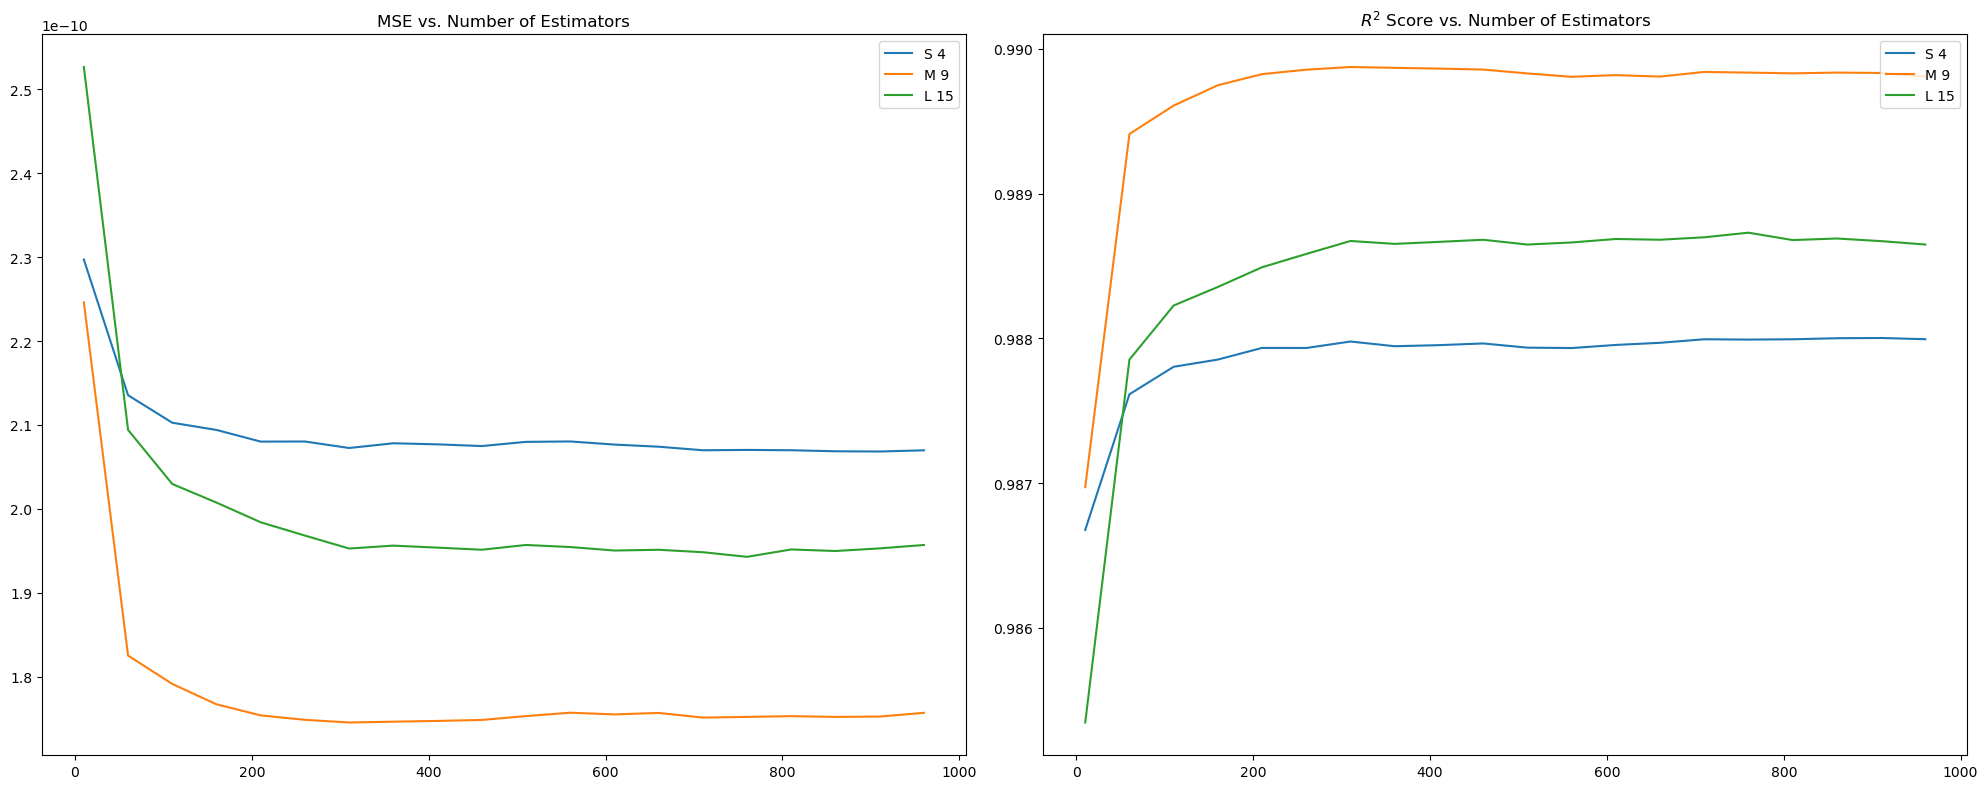

In [36]:
fig, axes = plt.subplots(1, 2,figsize=(20, 8))
for name, (mse, score, _) in results.items():
    axes[0].plot(n_estimators_range, mse, label=name + " " + str(len(feature_groups[name])))
    axes[1].plot(n_estimators_range, score, label=name + " " + str(len(feature_groups[name])))
axes[0].set_title('MSE vs. Number of Estimators')
axes[0].legend(loc="upper right")
axes[1].set_title('$R^2$ Score vs. Number of Estimators')
axes[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

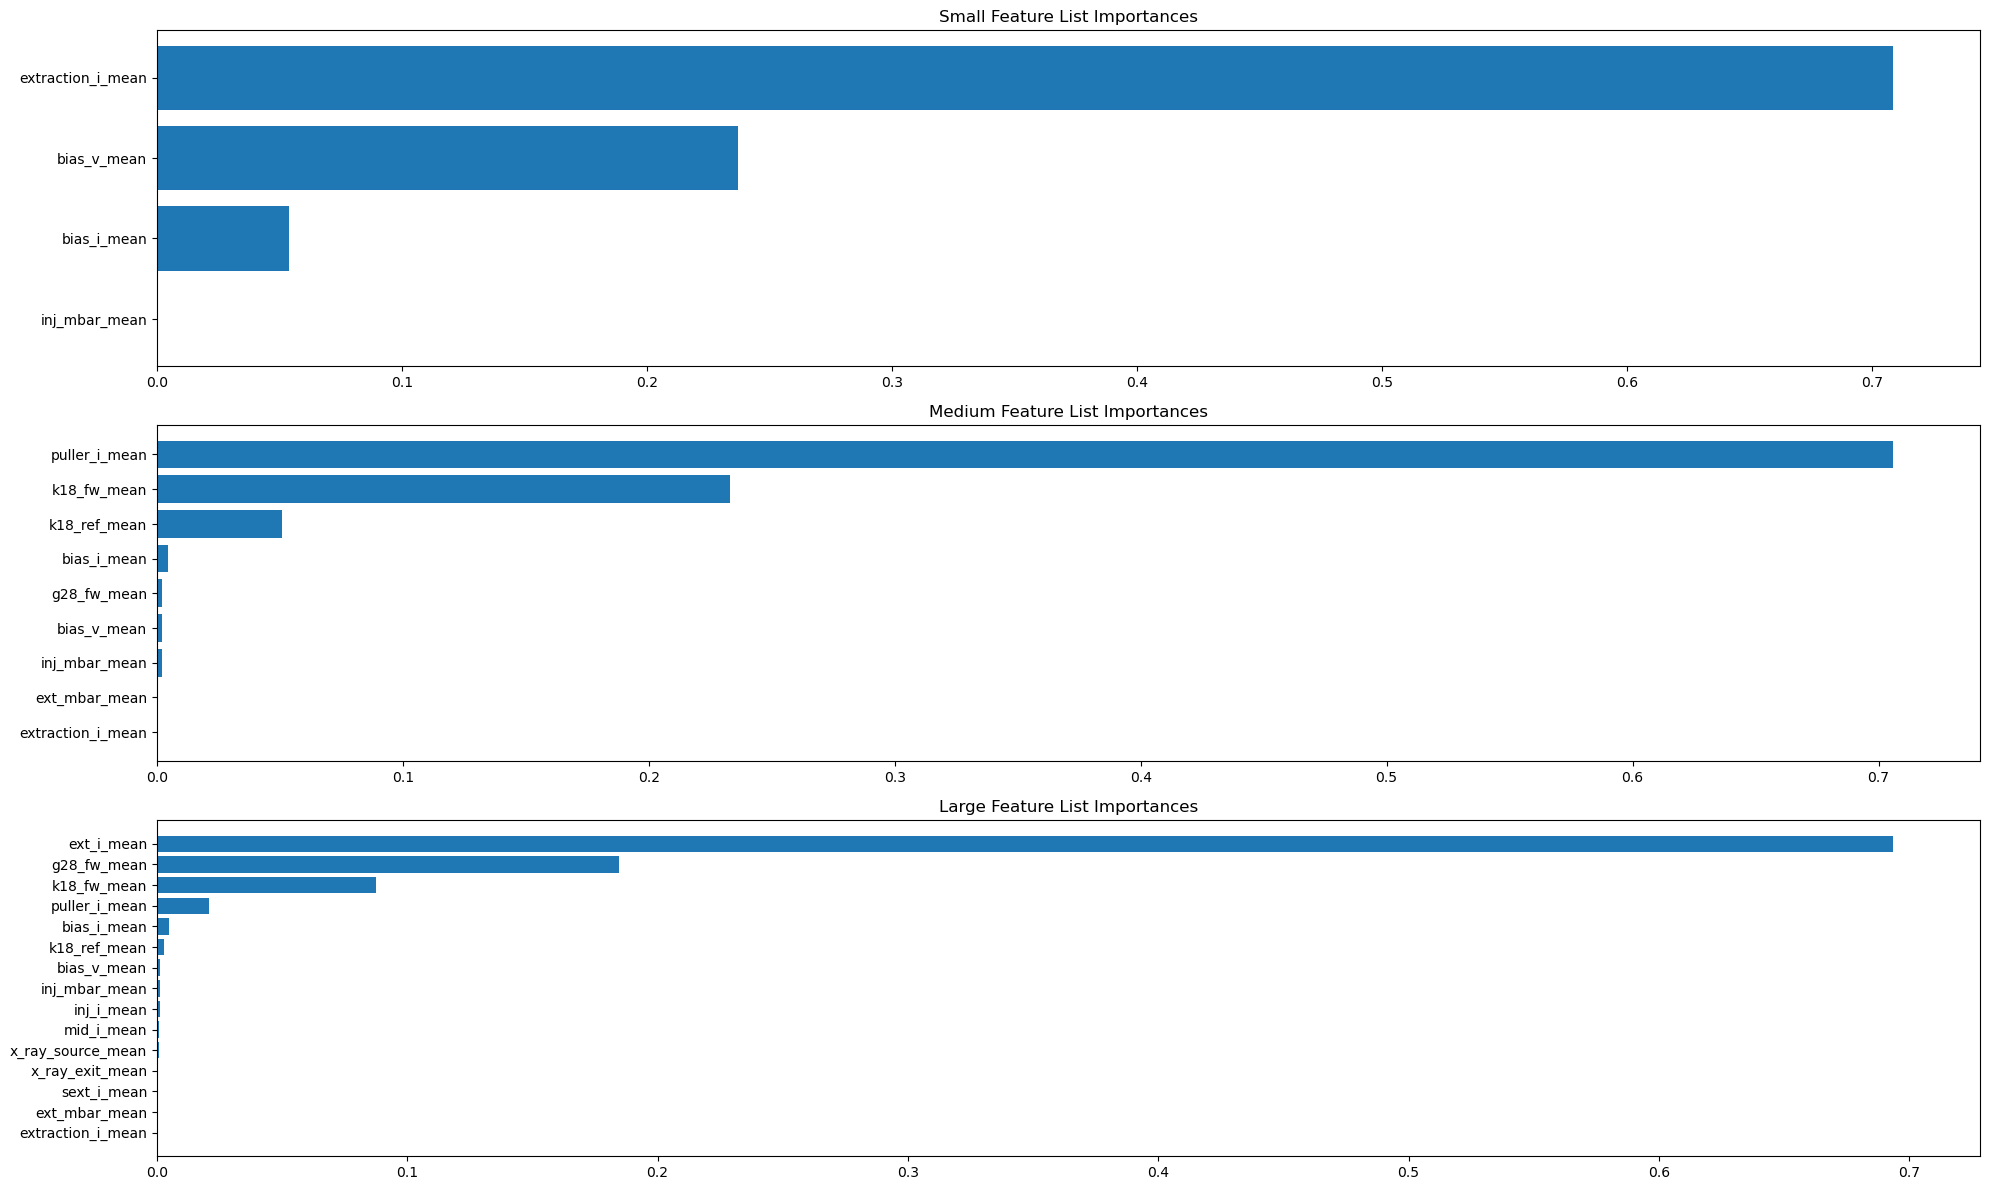

In [37]:
fig, axes = plt.subplots(3, 1 ,figsize=(20, 12))
for i, (name, (_, _, importances)) in enumerate(results.items()):
    importances = importances[len(importances)//2]
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(sorted_idx)) + 0.5
    axes[i].barh(padding, importances[sorted_idx])
    axes[i].set_yticks(padding, np.array(get_features(feature_groups[name], std=False))[sorted_idx])
axes[0].set_title('Small Feature List Importances')
axes[1].set_title('Medium Feature List Importances')
axes[2].set_title('Large Feature List Importances')
plt.tight_layout()
plt.show()

### Train/Validate with runs 5 and 9

In [38]:
n_estimators_range = range(10,1001, 50)
results = {group: ([],[],[]) for group in datasets.keys()}

for group, dataset in datasets.items():
    train_x, train_y, test_x, test_y = both_run(dataset, 5,9)
    for n_estimators in n_estimators_range:
        rf_args = {
            "n_estimators":n_estimators, 
            # "max_features": "log2",
            "random_state": random_state,
            "n_jobs": -1
        }
        rf = RandomForest(rf_args)
        rf.fit(train_x, train_y)
        mse = rf.evaluate(test_x, test_y)
        score = rf.model.score(test_x, test_y)
        importances = rf.model.feature_importances_
        results[group][0].append(mse)
        results[group][1].append(score)
        results[group][2].append(importances)

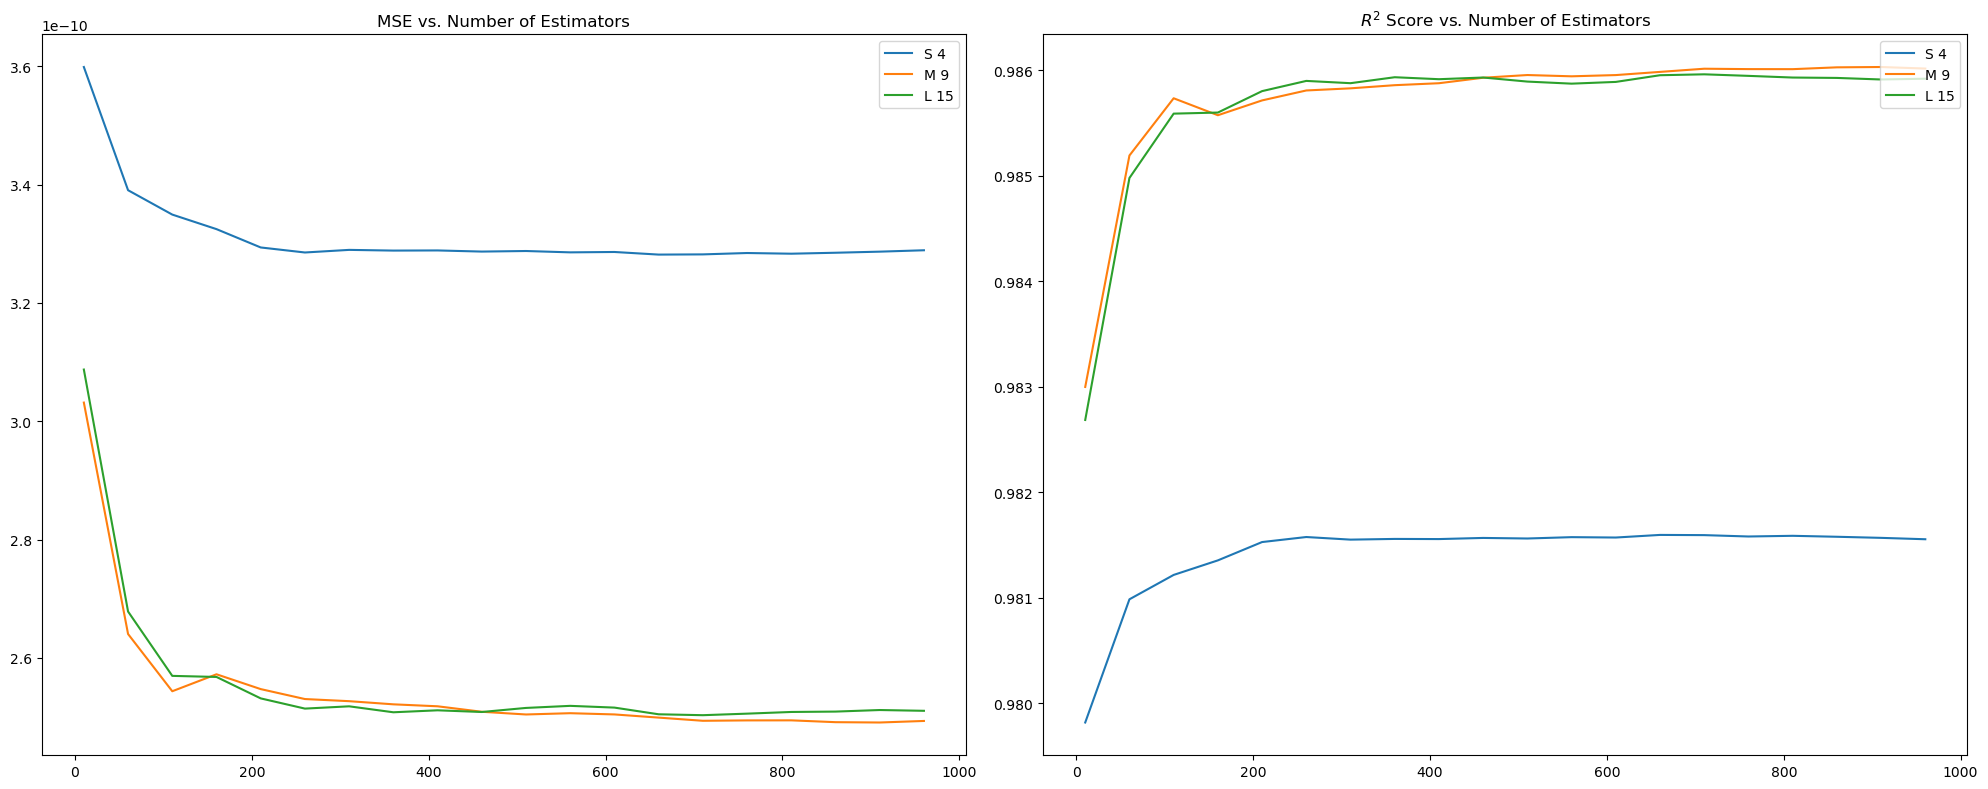

In [39]:
fig, axes = plt.subplots(1, 2,figsize=(20, 8))
for name, (mse, score, _) in results.items():
    axes[0].plot(n_estimators_range, mse, label=name + " " + str(len(feature_groups[name])))
    axes[1].plot(n_estimators_range, score, label=name + " " + str(len(feature_groups[name])))
axes[0].set_title('MSE vs. Number of Estimators')
axes[0].legend(loc="upper right")
axes[1].set_title('$R^2$ Score vs. Number of Estimators')
axes[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

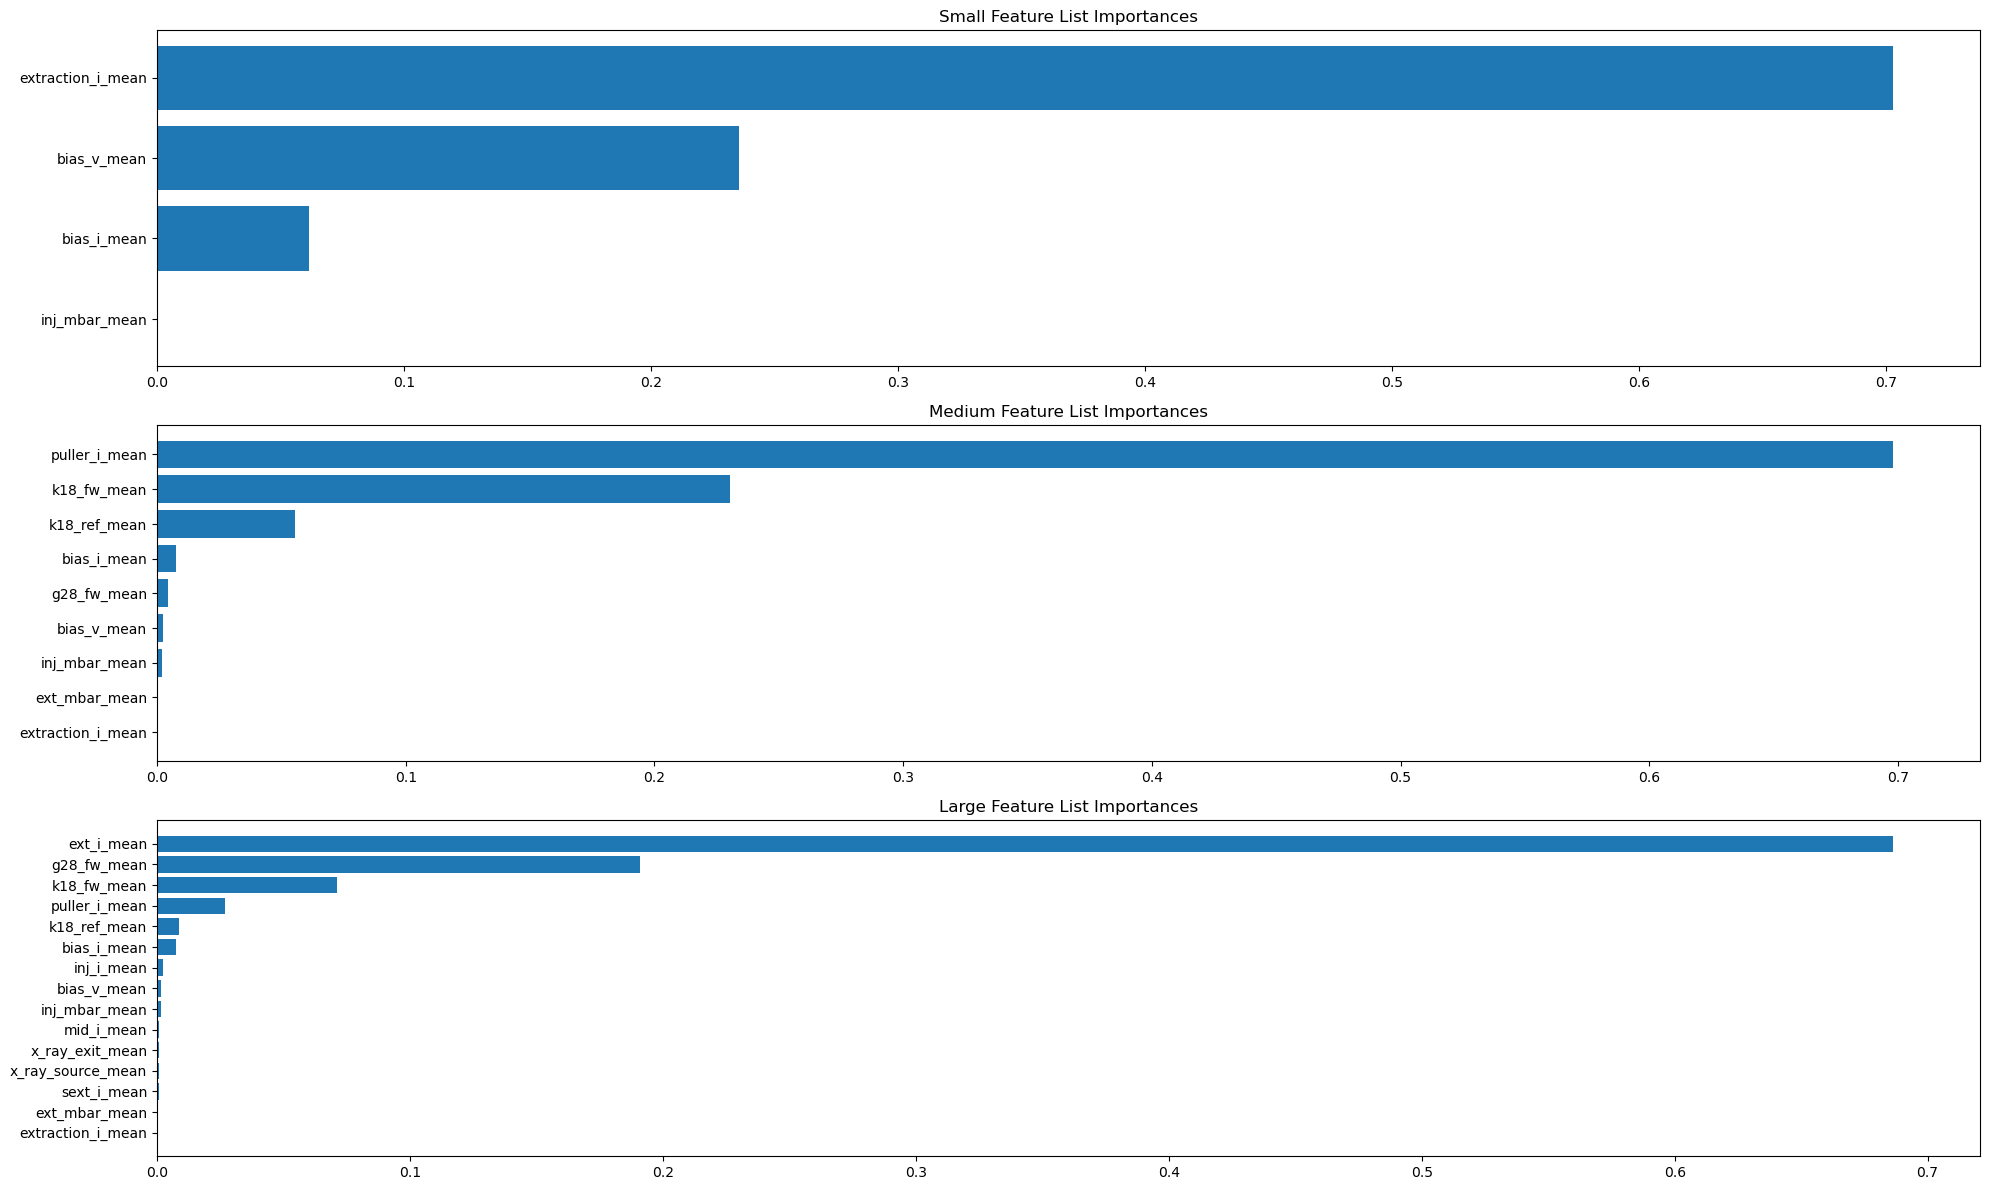

In [40]:
fig, axes = plt.subplots(3, 1 ,figsize=(20, 12))
for i, (name, (_, _, importances)) in enumerate(results.items()):
    importances = importances[len(importances)//2]
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(sorted_idx)) + 0.5
    axes[i].barh(padding, importances[sorted_idx])
    axes[i].set_yticks(padding, np.array(get_features(feature_groups[name], std=False))[sorted_idx])
axes[0].set_title('Small Feature List Importances')
axes[1].set_title('Medium Feature List Importances')
axes[2].set_title('Large Feature List Importances')
plt.tight_layout()
plt.show()

## Train on 5, Validate on 9

In [41]:
n_estimators_range = range(10,1001, 50)
results = {group: ([],[],[]) for group in datasets.keys()}

for group, dataset in datasets.items():
    train_x, train_y, test_x, test_y = train_and_test(dataset, 5, 9)
    for n_estimators in n_estimators_range:
        rf_args = {
            "n_estimators":n_estimators, 
            # "max_features": "log2",
            "random_state": random_state,
            "n_jobs": -1
        }
        rf = RandomForest(rf_args)
        rf.fit(train_x, train_y)
        mse = rf.evaluate(test_x, test_y)
        score = rf.model.score(test_x, test_y)
        importances = rf.model.feature_importances_
        results[group][0].append(mse)
        results[group][1].append(score)
        results[group][2].append(importances)

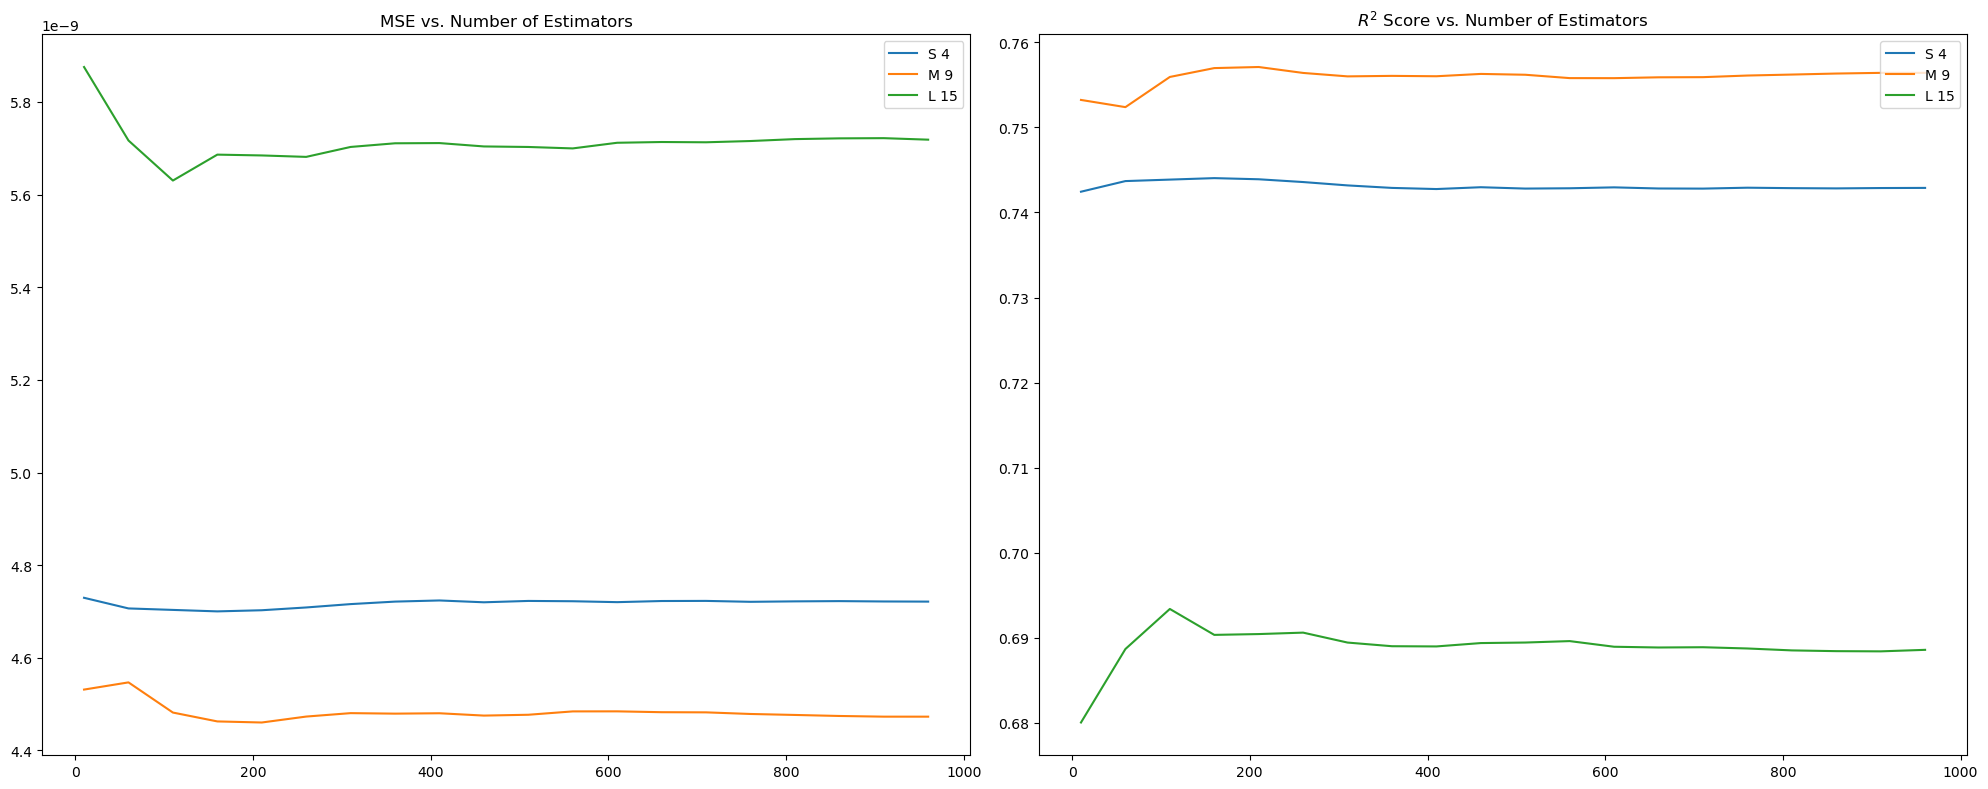

In [42]:
fig, axes = plt.subplots(1, 2,figsize=(20, 8))
for name, (mse, score, _) in results.items():
    axes[0].plot(n_estimators_range, mse, label=name + " " + str(len(feature_groups[name])))
    axes[1].plot(n_estimators_range, score, label=name + " " + str(len(feature_groups[name])))
axes[0].set_title('MSE vs. Number of Estimators')
axes[0].legend(loc="upper right")
axes[1].set_title('$R^2$ Score vs. Number of Estimators')
axes[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

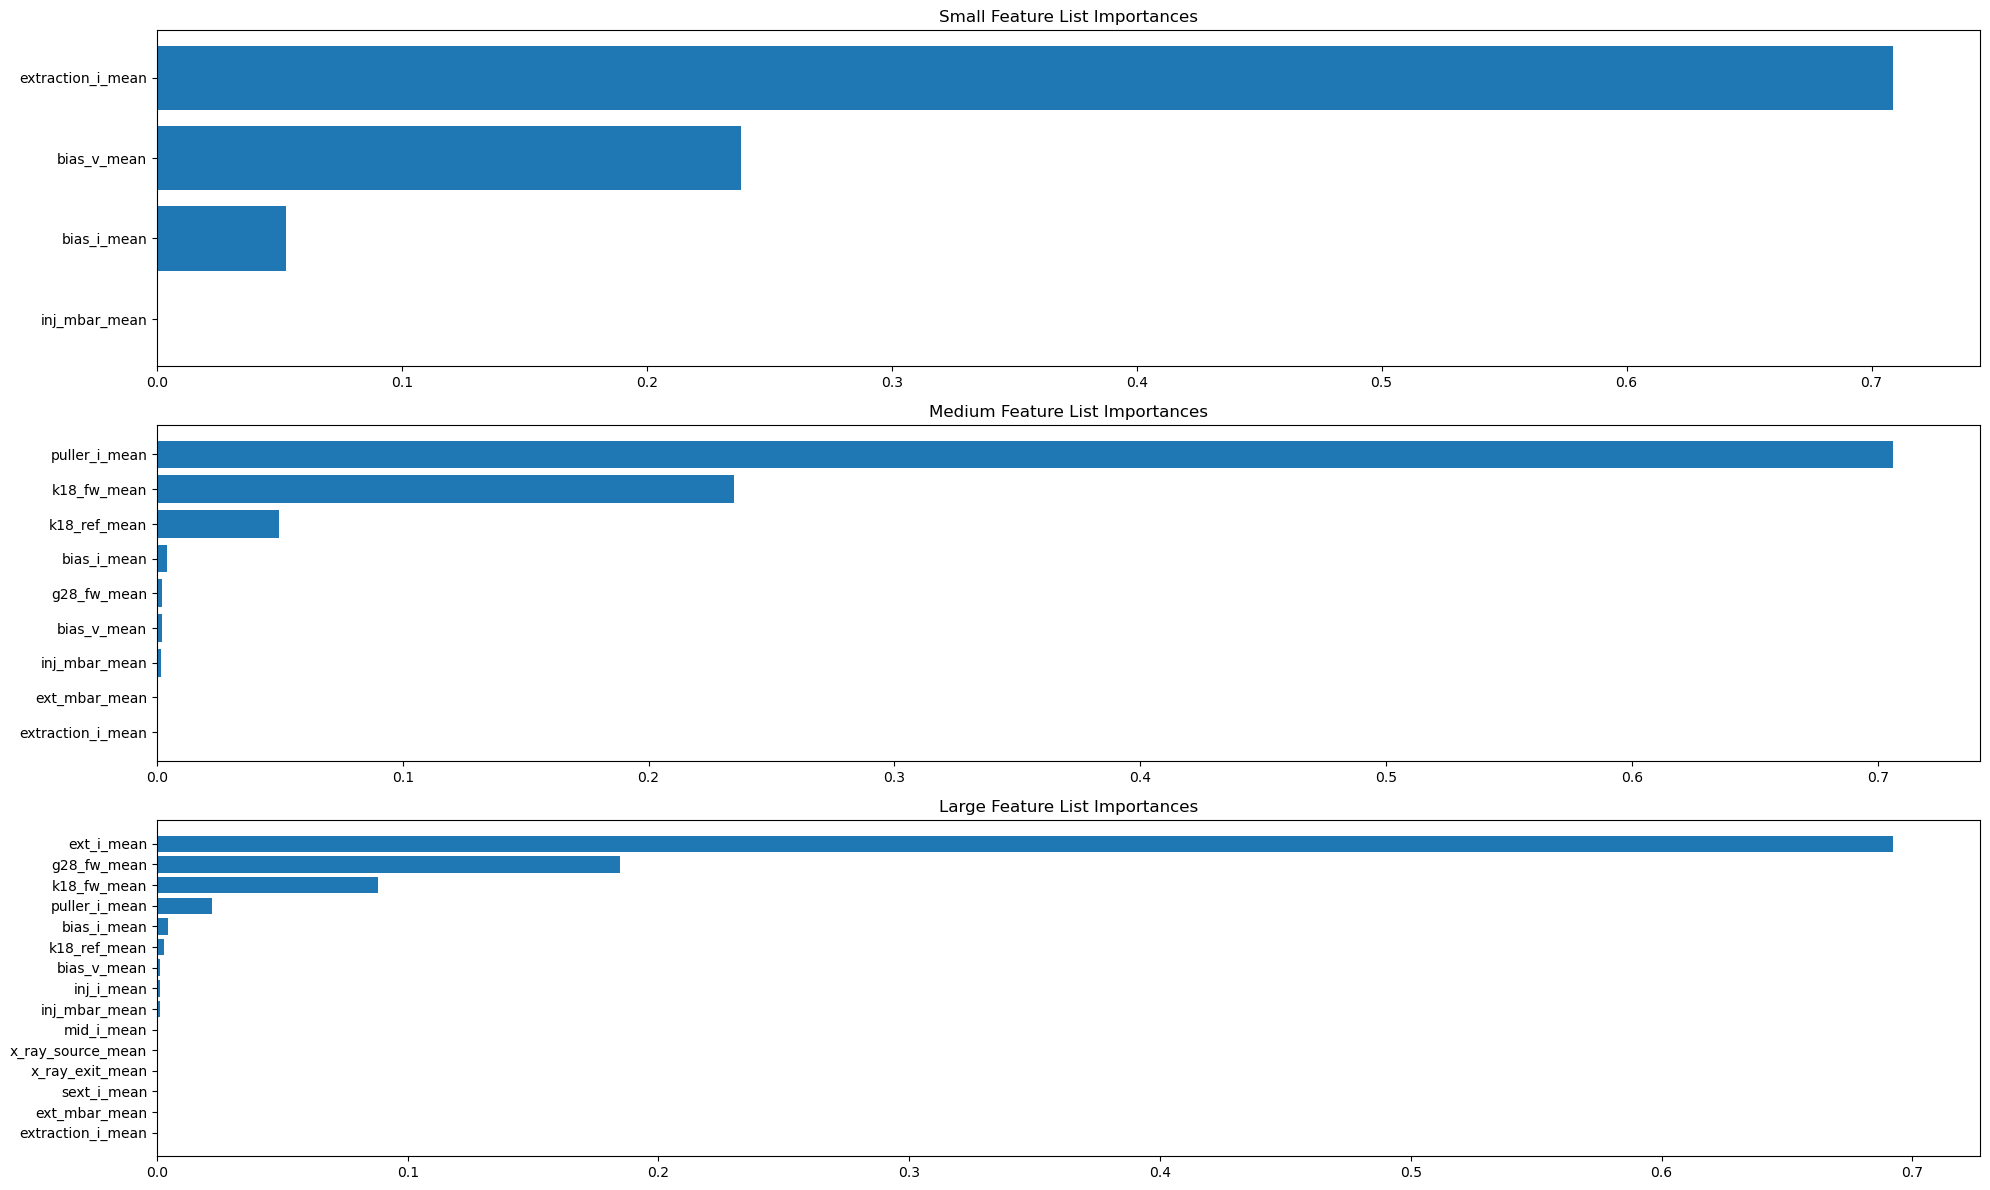

In [43]:
fig, axes = plt.subplots(3, 1 ,figsize=(20, 12))
for i, (name, (_, _, importances)) in enumerate(results.items()):
    importances = importances[len(importances)//2]
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(sorted_idx)) + 0.5
    axes[i].barh(padding, importances[sorted_idx])
    axes[i].set_yticks(padding, np.array(get_features(feature_groups[name], std=False))[sorted_idx])
axes[0].set_title('Small Feature List Importances')
axes[1].set_title('Medium Feature List Importances')
axes[2].set_title('Large Feature List Importances')
plt.tight_layout()
plt.show()

## Permutation Importances
To get a better idea of what features actually make an impact on prediction ability
Will train with 200 estimators b/c validation error seemed to stabilize by then

In [44]:
rf_args = {
    "n_estimators":200, 
    "random_state": random_state,
    "n_jobs": -1
}
importances_list = []
for group, dataset in datasets.items():
    # train_x, train_y, test_x, test_y = one_run(dataset, 5)
    # train_x, train_y, test_x, test_y =  both_run(dataset, 5, 9)
    train_x, train_y, test_x, test_y =  train_and_test(dataset, 5, 9)
    rf = RandomForest(rf_args)
    rf.fit(train_x, train_y)
    importances = permutation_importance(rf.model, test_x, test_y, n_repeats=30).importances_mean
    importances_list.append((group, importances))

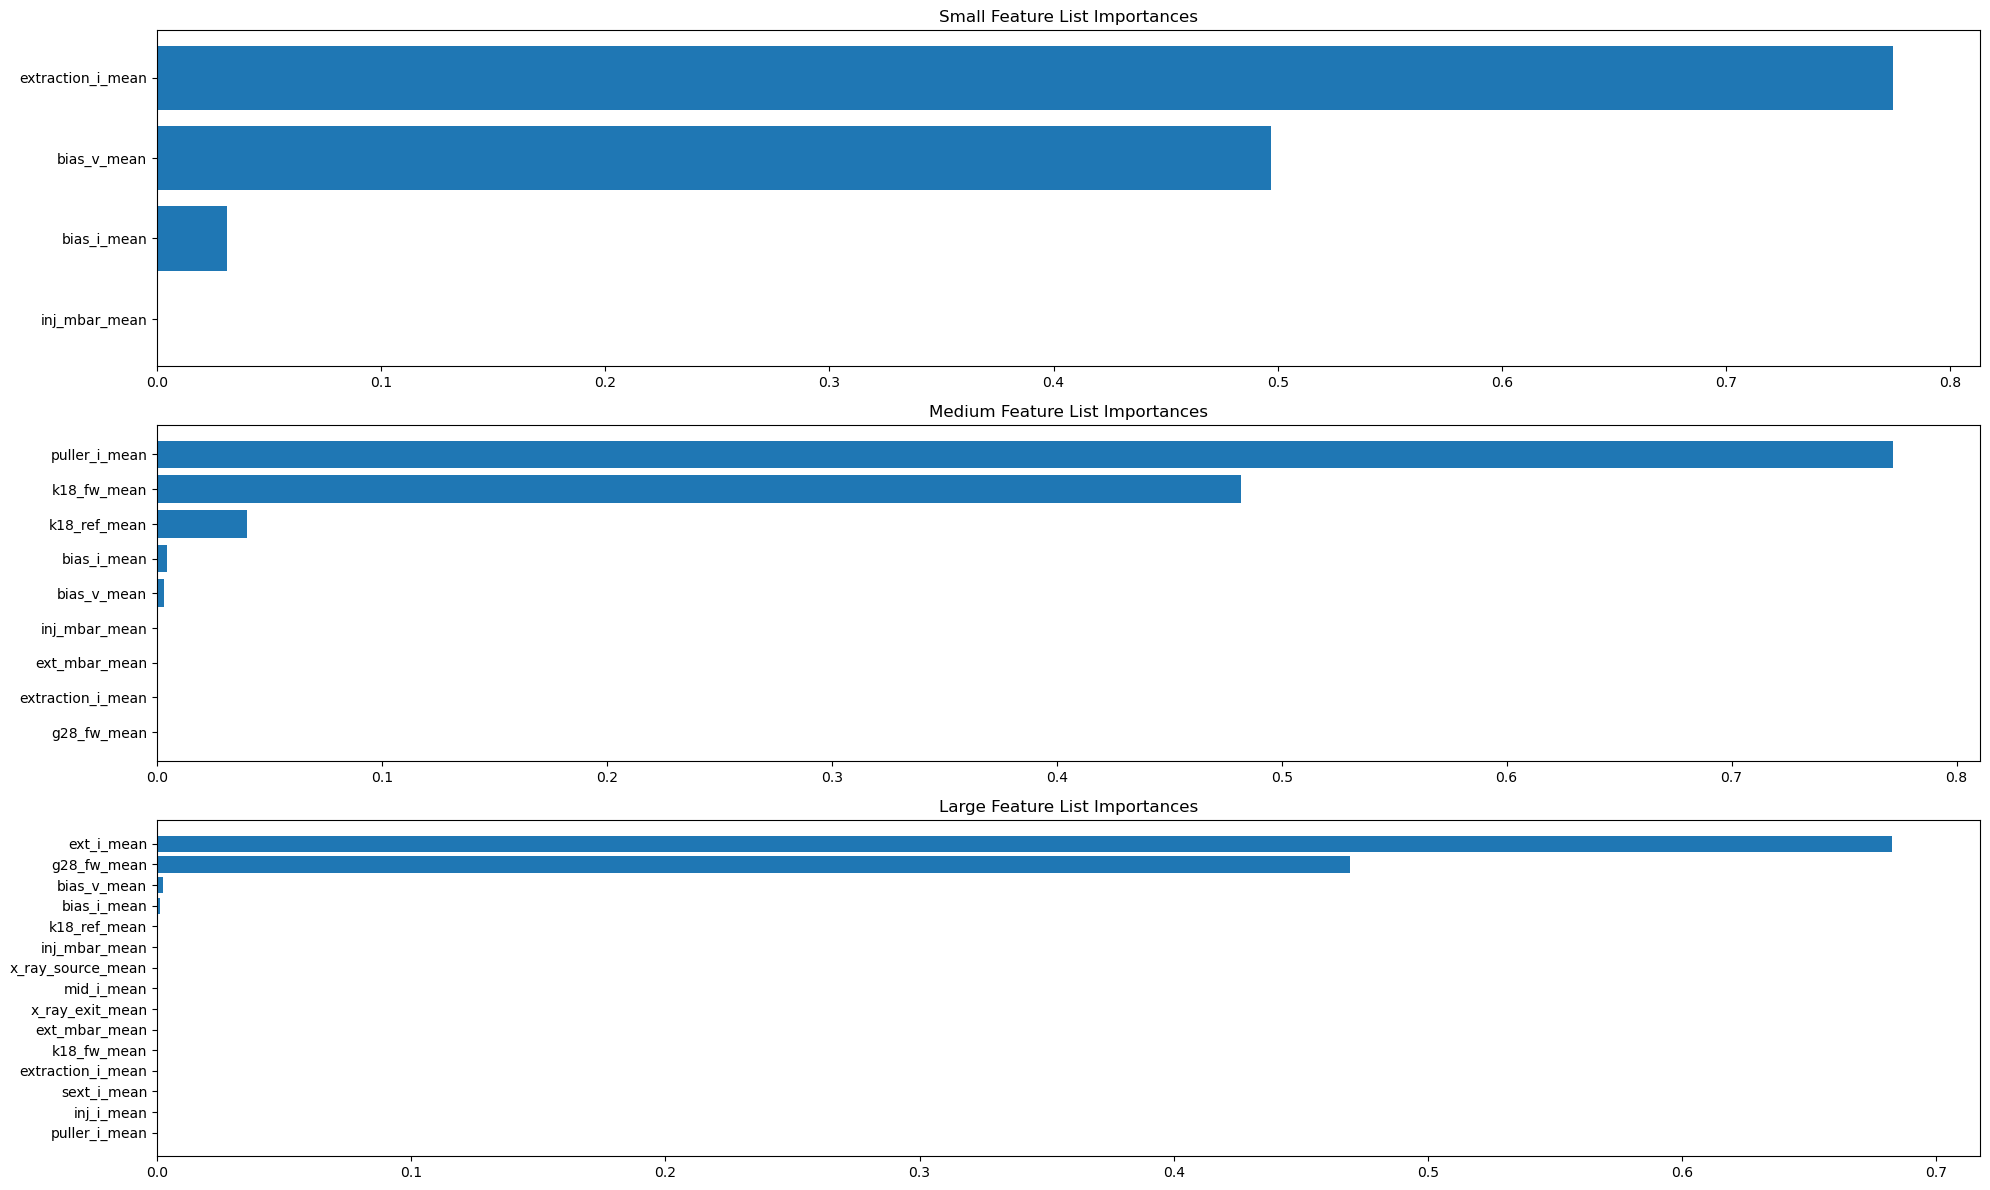

In [45]:
fig, axes = plt.subplots(3, 1 ,figsize=(20, 12))
for i, (name,importances) in enumerate(importances_list):
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(sorted_idx)) + 0.5
    axes[i].barh(padding, importances[sorted_idx])
    axes[i].set_yticks(padding, np.array(get_features(feature_groups[name], std=False))[sorted_idx])
    axes[i].set_xlim(0)
axes[0].set_title('Small Feature List Importances')
axes[1].set_title('Medium Feature List Importances')
axes[2].set_title('Large Feature List Importances')
plt.tight_layout()
plt.show()

# Neural Network
Using the same splits